In [1]:
# import os 
# path="C:/Users/Administrator/Desktop/DARN程序"
# os.chdir(path)  
# os.listdir(path)


In [2]:
from functools import lru_cache
import numpy as np
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader,TensorDataset
import shutil
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import mmd
import xlrd
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 实验参数设置

In [3]:
# 设置系统随机状态
torch.manual_seed(0)  
# 训练epoch次数
max_epoch = 100        
# 源域文件路径
source_location='C:/Users/Administrator/Desktop/DARN程序/源域/GAST/n213_n216_n227_all.xlsx'
# 源域训练测试比例划分
source_test_size=59/1959 
# 目标域文件路径
target_location='C:/Users/Administrator/Desktop/DARN程序/目标域/GAST/泸205_GAST.csv'
# 目标域训练测试比例划分
target_test_size=4/54
# 输入神经元设置
net_input=5
# 目标域测试结果保存路径
savepath="C:/Users/Administrator/Desktop/new_draw_picture/H203gast_darn_DARN_GAST.csv"
# 测试目标域岩心对应测井数据/整个层位测井数据文件
# Testpath="C:/Users/Administrator/Desktop/new_draw_picture/H203/黄203_wire.csv"
Testpath=target_location

In [4]:
"""源域数据加载"""
df1=pd.read_excel(source_location)
data2=df1.values
all_data=data2[:,1:]
x=all_data[:,0:-1]# 源域测井特征
y=all_data[:,-1]  # 源域岩心标签
y = y.reshape(-1,1)
print(f"源域数据信息{data2.shape}")

源域数据信息(1959, 7)


In [5]:
"""源域数据标准化"""
from sklearn.preprocessing import StandardScaler
mm_scale=StandardScaler()
x = mm_scale.fit_transform(x)


In [6]:
"""切分源域数据集"""
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=source_test_size,random_state=55)
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)
Train_set = TensorDataset(x_train,y_train)
Train_Loader = DataLoader(dataset=Train_set,batch_size=50,shuffle=True)

In [7]:
"""目标域数据加载"""
tabel=pd.read_csv(target_location)
data2=tabel.values
all_data=data2[:,1:]
target_data=all_data[:,0:-1]
target_label=all_data[:,-1]
target_label = target_label.reshape(-1,1)
print(f"目标领域数据信息{target_data.shape}")

目标领域数据信息(54, 5)


In [8]:
"""目标域数据标准化"""
trget_data = mm_scale.fit_transform(target_data)



In [9]:
"""切分目标域数据集"""
Tx_train,Tx_test,Ty_train,Ty_test = train_test_split(target_data,target_label,test_size=target_test_size,random_state=55)
Tx_train = torch.from_numpy(Tx_train).type(torch.FloatTensor)
Tx_test = torch.from_numpy(Tx_test).type(torch.FloatTensor)
Ty_train = torch.from_numpy(Ty_train).type(torch.FloatTensor)
Ty_test = torch.from_numpy(Ty_test).type(torch.FloatTensor)
Target_Train_set = TensorDataset(Tx_train,Ty_train)
Target_Train_Loader = DataLoader(dataset=Target_Train_set,batch_size=50,shuffle=True)

In [10]:
'''封装目标域数据迭代器'''
T_Data=iter(Target_Train_Loader)
T_iter_num=len(T_Data)
print(T_iter_num)

1


In [11]:
"""加载网络模型"""
from DaNN import DaNN_R
model=DaNN_R(n_input=net_input)

In [12]:
"""初始化网络参数"""
for m in model.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal(m.weight.data)
        nn.init.xavier_normal(m.weight.data)
        nn.init.kaiming_normal(m.weight.data)#卷积层参数初始化
        m.bias.data.fill_(0)
    elif isinstance(m,nn.Linear):
        nn.init.kaiming_normal_(m.weight)#全连接层参数初始化

In [13]:
"""定义mmd损失函数"""
GAMMA = 10 ^ 3
def mmd_loss(x_src, x_tar):
    return mmd.mix_rbf_mmd2(x_src, x_tar, [GAMMA])

In [14]:
"""定义优化器和损失函数"""
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

In [15]:
"""定义训练好的模型保存路径"""
save_path='./Output/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [16]:
"""开始训练"""
loss_list=[]  # 记录所有loss的值
min_cost=3000 # 选出最小的loss，定义初值
model.train()
for epoch in range(max_epoch):
    all_loss=0
    for j ,data in enumerate(Train_Loader):
        x_train,y_train=data
        t_x_train,t_y_train=T_Data.next()
        if j % T_iter_num == 0:
            T_Data=iter(Target_Train_Loader)
        # 前向传播
        y_src, x_src_mmd, x_tar_mmd,x_src_64,x_tar_64 ,x_src_31,x_tar_31= model(x_train,t_x_train) # 源域预测 
        # 计算loss + 单核MMD
        loss = criterion(y_src, y_train)
        loss_mmd = mmd_loss(x_src_mmd, x_tar_mmd)  # MMD对齐
        loss_mmd_64 = mmd_loss(x_src_64, x_tar_64)
        loss_mmd_31 = mmd_loss(x_src_31, x_tar_31)
        loss = 0.6 * loss_mmd + loss + 0.2 * loss_mmd_64 + 0.2 * loss_mmd_31      
        # 梯度清0
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 权重调整
        optimizer.step()
        all_loss+=loss.detach().numpy()
    ExpLR.step()
    # 间隔打印信息
    if epoch%5==0:
        print('Epoch:',epoch,'Loss',all_loss)
    loss_list.append(all_loss)
    if all_loss < min_cost:
        min_cost = all_loss
        save_name = save_path +'best.pth'
        torch.save(model.state_dict(), save_name)
    if epoch==max_epoch-1:
        
        print(f"min_cost={min_cost}")

Epoch: 0 Loss 176.8077552318573
Epoch: 5 Loss 54.8966680765152
Epoch: 10 Loss 42.78321832418442
Epoch: 15 Loss 33.1913143992424
Epoch: 20 Loss 27.29860669374466
Epoch: 25 Loss 22.626017779111862
Epoch: 30 Loss 20.416248351335526
Epoch: 35 Loss 18.340218722820282
Epoch: 40 Loss 18.031813859939575
Epoch: 45 Loss 16.69482484459877
Epoch: 50 Loss 15.479837268590927
Epoch: 55 Loss 15.758082747459412
Epoch: 60 Loss 15.05844134092331
Epoch: 65 Loss 14.721337348222733
Epoch: 70 Loss 14.326014697551727
Epoch: 75 Loss 13.808143645524979
Epoch: 80 Loss 14.24901369214058
Epoch: 85 Loss 13.011833041906357
Epoch: 90 Loss 13.371005550026894
Epoch: 95 Loss 12.79176351428032
min_cost=12.79176351428032


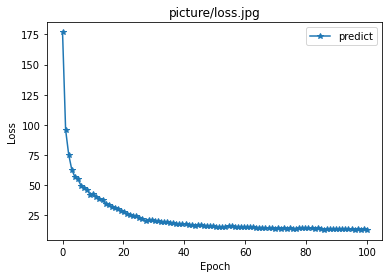

In [17]:
"""
汇制训练损失图
"""
def plt_loss_curve(loss_list,Epoch,fig_name):
    x = np.linspace(0, Epoch,Epoch)
    y=np.array(loss_list)
    plt.plot(x, y, label='predict',marker='*')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(fig_name )
    plt.legend()
    plt.savefig(fig_name)
    plt.show()
plt_loss_curve(loss_list,max_epoch,"picture/loss.jpg")

## 测试阶段

In [18]:
"""测试--加载最好的模型进行测试"""
model = DaNN_R(n_input=net_input)
model_weight_path = './Output/best.pth'
model.load_state_dict(torch.load(model_weight_path))
model.eval()

DaNN_R(
  (layer_input1): Linear(in_features=5, out_features=31, bias=True)
  (layer_input2): Linear(in_features=31, out_features=64, bias=True)
  (layer_input3): Linear(in_features=64, out_features=31, bias=True)
  (layer_input4): Linear(in_features=31, out_features=1, bias=True)
  (layer_input5): Linear(in_features=31, out_features=31, bias=True)
  (layer_input6): Linear(in_features=31, out_features=31, bias=True)
  (layer_input7): Linear(in_features=31, out_features=31, bias=True)
  (relu): GELU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [19]:
"""加载目标域测试数据—岩心对于测井参数/对应所有层的测井数据"""
df1=pd.read_csv(Testpath)
data2=df1.values
all_data=data2[:,1:]
target_data=all_data[:,0:-1]
target_label=all_data[:,-1]
target_label = target_label.reshape(-1,1)
print(f"目标领域数据数量{target_data.shape[0]}")
"""目标域数据标准化并转化为tensor格式"""
target_data = mm_scale.fit_transform(target_data)
Tx_train = torch.from_numpy(target_data).type(torch.FloatTensor)
Ty_train = torch.from_numpy(target_label).type(torch.FloatTensor)

目标领域数据数量54


In [20]:
Ty_test=Ty_train
Tx_test=Tx_train
MAE = nn.L1Loss()
with torch.no_grad():

    output, _, _ ,_,_,_,_= model(Tx_test, Tx_test) # 目标域测试集
    loss = criterion(output, Ty_test)
    predict_list = output.detach().numpy()
    """目标域测试结果写入表中"""
    data_result = {'real_value': np.round(Ty_test.numpy().flatten(), 2).tolist(),
                   'pred_value': np.round(output.numpy().flatten(), 2).tolist()}
    dataframe = pd.DataFrame(data_result, columns=['real_value', 'pred_value'])
    dfA = pd.concat([df1, dataframe], axis=1)
    dfA.to_csv(savepath, index=False)
    predict_list = output.detach().numpy()
    """MAE损失"""
    MAE_LOSS=MAE(output,Ty_test)
    print(f'目标域平均绝对误差为:{MAE_LOSS}')
    print(f'目标域测试均方误差为：{loss}')
    output_sourc, _, _,_,_ ,_,_= model(x_test, x_test)
    loss_source = criterion(output_sourc, y_test)
    S_MAE_LOSS = MAE(output_sourc, y_test)
    souce_predict_list = output_sourc.detach().numpy()
    print(f'源域测试平均绝对误差为：{S_MAE_LOSS}')
    print(f'源域测试均方误差为：{loss_source}')
# 目标域相对误差
def mean_relative_error(y_true, y_pred,):
    import numpy as np
    relative_error = np.average(np.abs((y_true - y_pred) / y_true)*100, axis=0)
    return relative_error
print(f"目标域相对误差：{mean_relative_error(Ty_test.detach().numpy(),predict_list)}")

目标域平均绝对误差为:0.6527197360992432
目标域测试均方误差为：0.6666388511657715
源域测试平均绝对误差为：0.3948727250099182
源域测试均方误差为：0.24467799067497253
目标域相对误差：[39.44385]


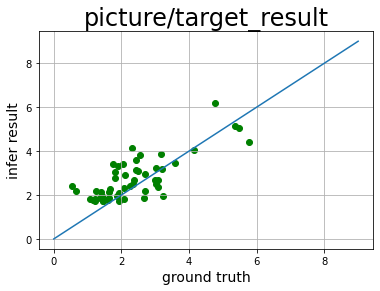

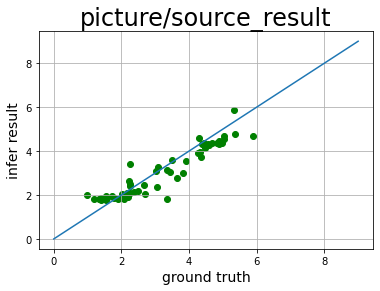

In [21]:
'''绘制真实值和预测值对比图'''
def draw_infer_result(groud_truths,infer_results,title):
    title=title
    plt.title(title, fontsize=24)
    x= np.arange(0,10) # 设置图幅范围
    plt.plot(x, x)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green')
    plt.grid()
    plt.savefig(title)
    plt.show()
draw_infer_result(Ty_test.detach().numpy(),predict_list,'picture/target_result')
draw_infer_result(y_test.detach().numpy(),souce_predict_list,'picture/source_result')